# FlexAttention Generation Results Analysis

This notebook analyzes the results from FlexAttention-based ensemble generation and compares them with traditional ensemble methods.

## Setup

In [ ]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add parent directory to path
sys.path.insert(0, '..')
from utils import partial_match, partial_match_scores

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
import torch

In [ ]:
a = torch.arrange(10)

AttributeError: module 'torch' has no attribute 'arrange'

## Configuration

Set the dataset and model to analyze:

In [19]:
# Configuration
DATASET = "webqa"  # or "myriadlama"
MODEL = "llama3.2_3b"  # e.g., "llama3.2_3b_it", "qwen2.5_7b_it"
NUM_PARAPHRASES = 5

# Construct paths - use absolute path to the actual dataset location
DATASET_ROOT = "/net/tokyo100-10g/data/str01_01/y-guo/datasets"
root = f"{DATASET_ROOT}/{DATASET}/{MODEL}"
print(f"Dataset root: {root}")
print(f"Exists: {os.path.exists(root)}")


Dataset root: /net/tokyo100-10g/data/str01_01/y-guo/datasets/webqa/llama3.2_3b
Exists: True


## Load FlexAttention Results

In [20]:
# Load FlexAttention results
flex_file = os.path.join(root, f"flex_attention-{NUM_PARAPHRASES}.feather")

if os.path.exists(flex_file):
    df_flex = pd.read_feather(flex_file)
    print(f"✅ Loaded FlexAttention results: {len(df_flex)} samples")
    print(f"\nColumns: {df_flex.columns.tolist()}")
    print(f"\nFirst few rows:")
    display(df_flex.head())
else:
    print(f"❌ FlexAttention results not found: {flex_file}")
    print(f"   Run: python flex_attention_generate.py --dataset {DATASET} --model {MODEL} --num_paraphrases {NUM_PARAPHRASES}")

✅ Loaded FlexAttention results: 2000 samples

Columns: ['uuid', 'answers', 'prediction', 'generation', 'paraphrases']

First few rows:


,uuid,answers,prediction,generation,paraphrases
0,36caa8a236f715c311f13b3fe6f4ba4b,"[Jamaican Creole English Language, Jamaican En...","Yes, Jamaican Creole is a creole language that...","Yes, Jamaican Creole is a creole language that...","[what does jamaican people speak?, what langua..."
1,ac93ee8cec7231ca642f4187a6d672c1,[Lawyer],a congressman,a congressman\n\nQ: what is the capital of the...,[what did james k polk do before he was presid...
2,ca5fd17b2ce6f38774b258b5f2b5da40,[University of Oregon],Oregon Ducks 2012 football schedule,Oregon Ducks 2012 football schedule\n\nQ: what...,[what is the oregon ducks 2012 football schedu...
3,20acb34dafe67599023d438dac1c3d60,[Tony Warren],William Roache,William Roache\n\nQ: what is the capital of th...,"[who plays ken barlow in coronation street?, w..."
4,2bbafc7c491b8234caf37bfb58d886a5,[Yaotsu],Sugihara’s life continued after his passing. H...,Sugihara’s life continued after his passing. H...,"[what happened after mr. sugihara died?, once ..."


## Compute Accuracy

In [21]:
# Check if lemmatized results are available
if "predict_lemma" in df_flex.columns and "answer_lemmas" in df_flex.columns:
    print("✅ Lemmatized results already available")
else:
    print("⚠️  Lemmatized results not available, adding lemmatization now...")
    
    # Add lemmatization directly in the notebook
    import spacy
    import numpy as np
    import multiprocessing as mp
    from tqdm import tqdm
    
    # Load spacy model
    print("Loading spacy model...")
    nlp = spacy.load("en_core_web_lg")
    
    def lemmaize_text(text):
        """Lemmatize a single text string"""
        doc = nlp(text)
        return [token.lemma_.lower() for token in doc]
    
    # Lemmatize predictions and answers
    print("Lemmatizing predictions...")
    predict_lemmas = []
    for pred in tqdm(df_flex["prediction"], desc="Predictions"):
        predict_lemmas.append(lemmaize_text(pred))
    
    print("Lemmatizing answers...")
    answer_lemmas = []
    for answers in tqdm(df_flex["answers"], desc="Answers"):
        answer_lemmas.append([lemmaize_text(ans) for ans in answers])
    
    # Add to dataframe
    df_flex["predict_lemma"] = predict_lemmas
    df_flex["answer_lemmas"] = answer_lemmas
    
    # Save back to file
    print(f"Saving lemmatized results to {flex_file}...")
    df_flex.to_feather(flex_file)
    print("✅ Lemmatization complete and saved")

# Process lemmas for accuracy computation
df_flex["answer_lemmas"] = df_flex["answer_lemmas"].apply(
    lambda xs: [list(x) for x in xs] if isinstance(xs, list) else xs
)

answers = df_flex["answer_lemmas"].tolist()
predictions = df_flex['predict_lemma'].tolist()

# Compute accuracy
flex_acc = partial_match_scores(predictions, answers)
print(f"\nFlexAttention Accuracy: {flex_acc:.3f}")

# Compute per-sample matches
matches = [partial_match(pred, ans, False) for pred, ans in zip(predictions, answers)]
df_flex['correct'] = matches

print(f"Correct predictions: {sum(matches)}/{len(matches)} ({sum(matches)/len(matches)*100:.1f}%)")


⚠️  Lemmatized results not available, adding lemmatization now...
Loading spacy model...
Lemmatizing predictions...
Lemmatizing predictions...


Predictions: 100%|██████████| 2000/2000 [00:07<00:00, 277.55it/s]


Lemmatizing answers...


Answers: 100%|██████████| 2000/2000 [00:15<00:00, 125.38it/s]

Saving lemmatized results to /net/tokyo100-10g/data/str01_01/y-guo/datasets/webqa/llama3.2_3b/flex_attention-5.feather...
✅ Lemmatization complete and saved

FlexAttention Accuracy: 0.272
Correct predictions: 543/2000 (27.2%)


## Sample Generations

Look at some example generations:

In [22]:
# Show some examples
print("Sample Generations:")
print("="*70)

for i in range(min(5, len(df_flex))):
    print(f"\nSample {i+1}:")
    print(f"  UUID: {df_flex.iloc[i]['uuid']}")
    print(f"  Answer: {df_flex.iloc[i]['answers']}")
    print(f"  Prediction: {df_flex.iloc[i]['prediction']}")
    if 'correct' in df_flex.columns:
        print(f"  Correct: {'✓' if df_flex.iloc[i]['correct'] else '✗'}")
    print(f"  Generation: {df_flex.iloc[i]['generation'][:150]}...")
    print("-"*70)

Sample Generations:

Sample 1:
  UUID: 36caa8a236f715c311f13b3fe6f4ba4b
  Answer: ['Jamaican Creole English Language' 'Jamaican English']
  Prediction: Yes, Jamaican Creole is a creole language that is related to a particular dialect of English
  Correct: ✗
  Generation: Yes, Jamaican Creole is a creole language that is related to a particular dialect of English...
----------------------------------------------------------------------

Sample 2:
  UUID: ac93ee8cec7231ca642f4187a6d672c1
  Answer: ['Lawyer']
  Prediction: a congressman
  Correct: ✗
  Generation: a congressman

Q: what is the capital of the united states?
A: Washington

Q:...
----------------------------------------------------------------------

Sample 3:
  UUID: ca5fd17b2ce6f38774b258b5f2b5da40
  Answer: ['University of Oregon']
  Prediction: Oregon Ducks 2012 football schedule
  Correct: ✗
  Generation: Oregon Ducks 2012 football schedule

Q: what is the capital of the united states?
A...
------------------------------

## Detailed Feature Export

Export all detailed features to CSV/Excel for comprehensive analysis. This includes:
- Original question
- Paraphrases
- Model input (prompt)
- Model output (generation)
- Processed output (prediction)
- Correct answers
- Correctness markers (✓/✗)

In [ ]:
def prepare_detailed_table(df):
    """
    Prepare a detailed table with all feature information.
    """
    detailed_data = []
    
    for idx, row in df.iterrows():
        item = {
            "Index": idx,
            "UUID": row.get("uuid", "N/A"),
            "Prediction": row.get("prediction", "N/A"),
            "Generation": row.get("generation", "N/A"),
            "Correct_Answers": str(row.get("answers", "N/A")),
        }
        
        # Add paraphrases if available
        if "paraphrases" in df.columns:
            paraphrases = row.get("paraphrases")
            if paraphrases is not None and not (isinstance(paraphrases, float) and pd.isna(paraphrases)):
                if isinstance(paraphrases, (list, tuple)):
                    for j, para in enumerate(paraphrases):
                        item[f"Paraphrase_{j}"] = para
        
        # Add lemmatized versions if available
        if "predict_lemma" in df.columns:
            predict_lemma = row.get("predict_lemma")
            if predict_lemma is not None and not (isinstance(predict_lemma, float) and pd.isna(predict_lemma)):
                item["Prediction_Lemma"] = str(predict_lemma)
        
        if "answer_lemmas" in df.columns:
            answer_lemmas = row.get("answer_lemmas")
            if answer_lemmas is not None and not (isinstance(answer_lemmas, float) and pd.isna(answer_lemmas)):
                item["Answer_Lemmas"] = str(answer_lemmas)
        
        # Calculate match for this specific prediction
        if "predict_lemma" in df.columns and "answer_lemmas" in df.columns:
            predict_lemma = row.get("predict_lemma")
            answer_lemmas = row.get("answer_lemmas")
            
            if predict_lemma is not None and answer_lemmas is not None:
                if not (isinstance(predict_lemma, float) and pd.isna(predict_lemma)):
                    if not (isinstance(answer_lemmas, float) and pd.isna(answer_lemmas)):
                        try:
                            if hasattr(answer_lemmas, '__iter__'):
                                answer_lemmas_list = []
                                for ans in answer_lemmas:
                                    if isinstance(ans, (list, tuple)):
                                        answer_lemmas_list.append(list(ans))
                                    else:
                                        answer_lemmas_list.append(list(ans) if hasattr(ans, '__iter__') and not isinstance(ans, str) else [ans])
                                
                                is_correct = partial_match(predict_lemma, answer_lemmas_list)
                                item["Is_Correct"] = "✓" if is_correct else "✗"
                            else:
                                item["Is_Correct"] = "N/A"
                        except Exception as e:
                            item["Is_Correct"] = "N/A"
                    else:
                        item["Is_Correct"] = "N/A"
                else:
                    item["Is_Correct"] = "N/A"
            else:
                item["Is_Correct"] = "N/A"
        else:
            item["Is_Correct"] = "N/A"
        
        detailed_data.append(item)
    
    return pd.DataFrame(detailed_data)

# Prepare detailed table
print("Preparing detailed feature table...")
detailed_df = prepare_detailed_table(df_flex)
print(f"✅ Detailed table prepared with {len(detailed_df)} rows and {len(detailed_df.columns)} columns")
print(f"\nColumns: {detailed_df.columns.tolist()}")

In [ ]:
# Display sample detailed data
print("Sample Detailed Data (first 5 entries):")
print("="*80)

# Show key columns for first few rows
key_cols = [c for c in ['Index', 'UUID', 'Prediction', 'Correct_Answers', 'Is_Correct'] if c in detailed_df.columns]
display(detailed_df[key_cols].head())

# Show full details for first entry
print("\nFull details for first entry:")
print("-"*80)
for col in detailed_df.columns:
    value = detailed_df.iloc[0][col]
    if isinstance(value, str) and len(value) > 100:
        value = value[:100] + "..."
    print(f"{col}: {value}")

In [ ]:
# Summary statistics
print("Summary Statistics from Detailed Table:")
print("="*80)

if "Is_Correct" in detailed_df.columns:
    correct_count = (detailed_df["Is_Correct"] == "✓").sum()
    incorrect_count = (detailed_df["Is_Correct"] == "✗").sum()
    na_count = (detailed_df["Is_Correct"] == "N/A").sum()
    
    print(f"Total samples: {len(detailed_df)}")
    if correct_count > 0 or incorrect_count > 0:
        print(f"Correct predictions: {correct_count} ({correct_count/len(detailed_df)*100:.1f}%)")
        print(f"Incorrect predictions: {incorrect_count} ({incorrect_count/len(detailed_df)*100:.1f}%)")
        if na_count > 0:
            print(f"Could not determine: {na_count}")
else:
    print("Is_Correct column not available")

### Export Detailed Table

Export the detailed table to CSV or Excel for further analysis:

In [ ]:
# Export to CSV
output_csv = os.path.join(root, f"flex_attention-{NUM_PARAPHRASES}_detailed.csv")
detailed_df.to_csv(output_csv, index=False, encoding='utf-8-sig')
print(f"✅ Detailed table exported to CSV: {output_csv}")

# Optionally export to Excel (requires openpyxl)
try:
    output_excel = os.path.join(root, f"flex_attention-{NUM_PARAPHRASES}_detailed.xlsx")
    detailed_df.to_excel(output_excel, index=False, engine='openpyxl')
    print(f"✅ Detailed table exported to Excel: {output_excel}")
except ImportError:
    print("⚠️  openpyxl not available, skipping Excel export")
    print("   Install with: pip install openpyxl")

## Compare with Traditional Ensemble Methods

In [12]:
# Load and compare with traditional ensemble methods
methods = ["avg", "max", "weighted_avg", "weighted_max"]
results = {}

for method in methods:
    ensemble_file = os.path.join(root, f"ensemble_{method}-{NUM_PARAPHRASES}.feather")
    
    if os.path.exists(ensemble_file):
        df_ensemble = pd.read_feather(ensemble_file)
        
        if "predict_lemma" in df_ensemble.columns and "answer_lemmas" in df_ensemble.columns:
            df_ensemble["answer_lemmas"] = df_ensemble["answer_lemmas"].apply(
                lambda xs: [list(x) for x in xs] if isinstance(xs, list) else xs
            )
            answers = df_ensemble["answer_lemmas"].tolist()
            predictions = df_ensemble['predict_lemma'].tolist()
            
            acc = partial_match_scores(predictions, answers)
            results[method] = acc
            print(f"{method:15s}: {acc:.3f}")

# Add FlexAttention results
if 'flex_acc' in locals():
    results['flex_attention'] = flex_acc
    print(f"{'flex_attention':15s}: {flex_acc:.3f}")

print(f"\nResults summary:")
for method, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"  {method:20s}: {acc:.3f}")

flex_attention : 0.350

Results summary:
  flex_attention      : 0.350


## Visualization: Method Comparison

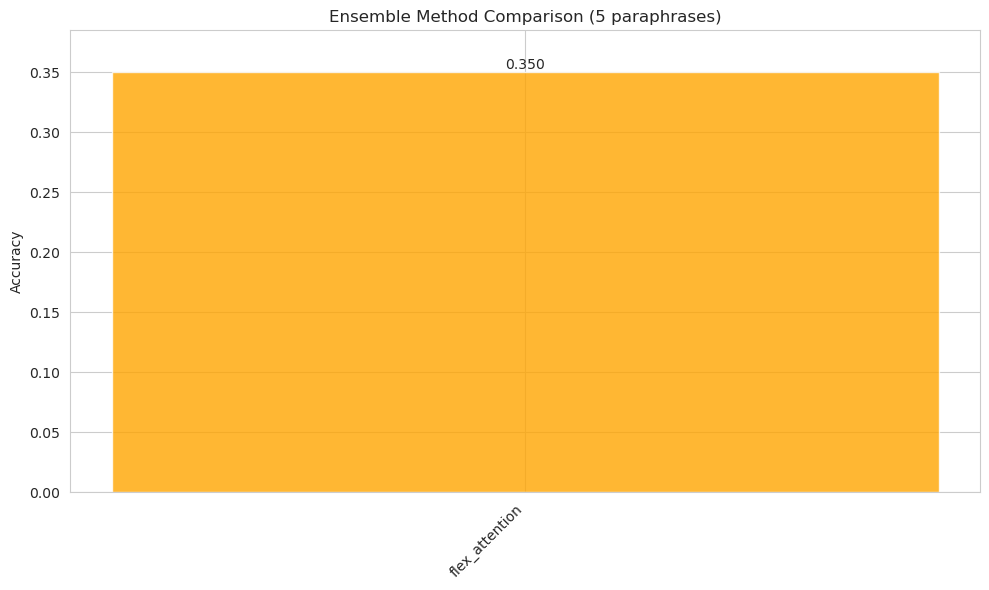

In [23]:
# Plot comparison
if results:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    methods_list = list(results.keys())
    accs_list = list(results.values())
    
    colors = ['skyblue' if m != 'flex_attention' else 'orange' for m in methods_list]
    
    bars = ax.bar(methods_list, accs_list, color=colors, alpha=0.8)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accs_list):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}',
                ha='center', va='bottom')
    
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Ensemble Method Comparison ({NUM_PARAPHRASES} paraphrases)')
    ax.set_ylim([0, max(accs_list) * 1.1])
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No results to plot")

## Effect of Number of Paraphrases

Compare FlexAttention performance with different numbers of paraphrases:

FlexAttention accuracy vs. number of paraphrases:
  5 paraphrases: 0.272


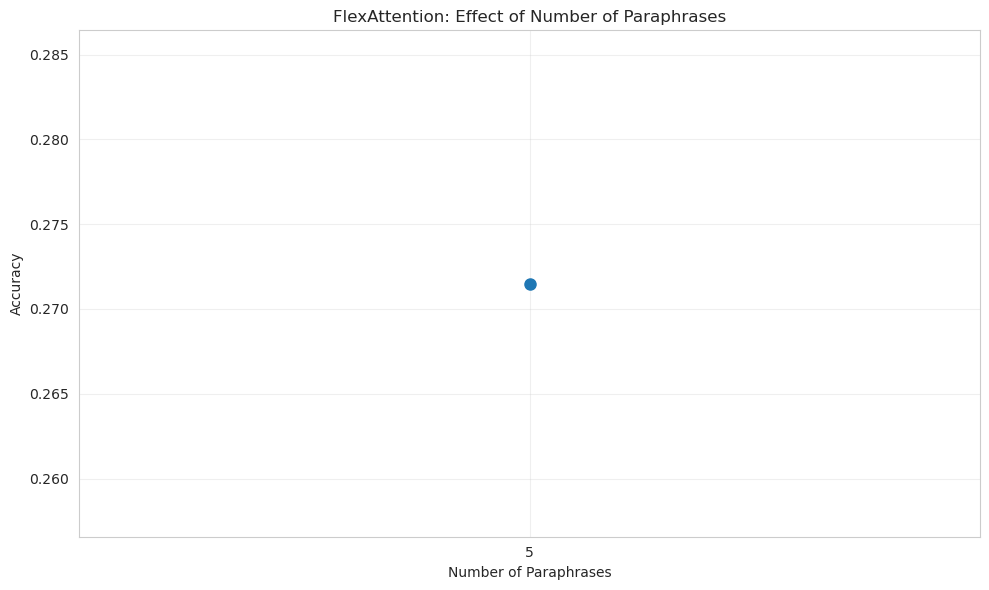


Best: 5 paraphrases with accuracy 0.272


In [24]:
# Compare different numbers of paraphrases
paraphrase_results = {}

for n in range(2, 11):
    flex_file = os.path.join(root, f"flex_attention-{n}.feather")
    
    if os.path.exists(flex_file):
        df = pd.read_feather(flex_file)
        
        if "predict_lemma" in df.columns and "answer_lemmas" in df.columns:
            df["answer_lemmas"] = df["answer_lemmas"].apply(
                lambda xs: [list(x) for x in xs] if isinstance(xs, list) else xs
            )
            answers = df["answer_lemmas"].tolist()
            predictions = df['predict_lemma'].tolist()
            
            acc = partial_match_scores(predictions, answers)
            paraphrase_results[n] = acc

if paraphrase_results:
    print("FlexAttention accuracy vs. number of paraphrases:")
    for n, acc in sorted(paraphrase_results.items()):
        print(f"  {n} paraphrases: {acc:.3f}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ns = list(paraphrase_results.keys())
    accs = list(paraphrase_results.values())
    
    ax.plot(ns, accs, marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('Number of Paraphrases')
    ax.set_ylabel('Accuracy')
    ax.set_title('FlexAttention: Effect of Number of Paraphrases')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(ns)
    plt.tight_layout()
    plt.show()
    
    # Find best
    best_n = max(paraphrase_results.items(), key=lambda x: x[1])
    print(f"\nBest: {best_n[0]} paraphrases with accuracy {best_n[1]:.3f}")
else:
    print("No results for different numbers of paraphrases")
    print("Generate them with: python flex_attention_generate.py --num_paraphrases N")

## Error Analysis

Look at cases where FlexAttention fails:

In [25]:
# Error analysis
if 'correct' in df_flex.columns:
    incorrect = df_flex[df_flex['correct'] == False]
    
    print(f"Incorrect predictions: {len(incorrect)} / {len(df_flex)}")
    print("\nSample incorrect predictions:")
    print("="*70)
    
    for i in range(min(5, len(incorrect))):
        row = incorrect.iloc[i]
        print(f"\nExample {i+1}:")
        print(f"  UUID: {row['uuid']}")
        print(f"  Expected: {row['answers']}")
        print(f"  Predicted: {row['prediction']}")
        print(f"  Generation: {row['generation'][:150]}...")
        print("-"*70)
else:
    print("Correctness information not available")

Incorrect predictions: 1457 / 2000

Sample incorrect predictions:

Example 1:
  UUID: 36caa8a236f715c311f13b3fe6f4ba4b
  Expected: ['Jamaican Creole English Language' 'Jamaican English']
  Predicted: Yes, Jamaican Creole is a creole language that is related to a particular dialect of English
  Generation: Yes, Jamaican Creole is a creole language that is related to a particular dialect of English...
----------------------------------------------------------------------

Example 2:
  UUID: ac93ee8cec7231ca642f4187a6d672c1
  Expected: ['Lawyer']
  Predicted: a congressman
  Generation: a congressman

Q: what is the capital of the united states?
A: Washington

Q:...
----------------------------------------------------------------------

Example 3:
  UUID: ca5fd17b2ce6f38774b258b5f2b5da40
  Expected: ['University of Oregon']
  Predicted: Oregon Ducks 2012 football schedule
  Generation: Oregon Ducks 2012 football schedule

Q: what is the capital of the united states?
A...
-----------------

## Summary Statistics

In [16]:
# Summary
print("="*70)
print("SUMMARY")
print("="*70)
print(f"\nDataset: {DATASET}")
print(f"Model: {MODEL}")
print(f"Number of paraphrases: {NUM_PARAPHRASES}")
print(f"Total samples: {len(df_flex)}")

if 'flex_acc' in locals():
    print(f"\nFlexAttention accuracy: {flex_acc:.3f}")
    
    if results:
        traditional_accs = [acc for method, acc in results.items() if method != 'flex_attention']
        if traditional_accs:
            avg_traditional = sum(traditional_accs) / len(traditional_accs)
            print(f"Average traditional ensemble: {avg_traditional:.3f}")
            improvement = flex_acc - avg_traditional
            print(f"Improvement: {improvement:+.3f} ({improvement/avg_traditional*100:+.1f}%)")

print("\n" + "="*70)

SUMMARY

Dataset: webqa
Model: qwen2.5_7b_it
Number of paraphrases: 5
Total samples: 2000

FlexAttention accuracy: 0.350



## Export Results

Export the complete analysis results to CSV for further analysis:

In [ ]:
# Export complete results table
export_dir = f"./exports"
os.makedirs(export_dir, exist_ok=True)

# Create base filename with dataset and model info
base_name = f"{DATASET}_{MODEL}_para{NUM_PARAPHRASES}"

# Export comprehensive detailed results with all information
print("Preparing comprehensive export...")
export_data = []

for idx, row in df_flex.iterrows():
    # Base information
    base_info = {
        'uuid': row['uuid'],
        'prediction': row['prediction'],
        'generation': row['generation'],
        'correct': row.get('correct', None),
    }
    
    # Add lemmatized info if available
    if 'predict_lemma' in df_flex.columns:
        base_info['predict_lemma'] = ' '.join(row['predict_lemma']) if isinstance(row['predict_lemma'], list) else str(row['predict_lemma'])
    
    # Add all answers
    if 'answers' in df_flex.columns:
        answers_list = row['answers']
        for i, ans in enumerate(answers_list):
            base_info[f'answer_{i+1}'] = ans
    
    # Add all paraphrases if available
    if 'paraphrases' in df_flex.columns:
        paraphrases = row['paraphrases']
        for i, para in enumerate(paraphrases):
            base_info[f'paraphrase_{i}'] = para
    
    export_data.append(base_info)

comprehensive_df = pd.DataFrame(export_data)
comprehensive_file = os.path.join(export_dir, f"{base_name}_comprehensive.csv")
comprehensive_df.to_csv(comprehensive_file, index=False)
print(f"✅ Exported comprehensive results to: {comprehensive_file}")
print(f"   Columns: {comprehensive_df.columns.tolist()}")

# Export FlexAttention detailed results (original format)
flex_export_file = os.path.join(export_dir, f"{base_name}_flex_attention_detailed.csv")
df_flex.to_csv(flex_export_file, index=False)
print(f"✅ Exported FlexAttention detailed results to: {flex_export_file}")

# Export accuracy comparison table
if results:
    comparison_df = pd.DataFrame([
        {"Method": method, "Accuracy": acc}
        for method, acc in sorted(results.items(), key=lambda x: x[1], reverse=True)
    ])
    comparison_file = os.path.join(export_dir, f"{base_name}_method_comparison.csv")
    comparison_df.to_csv(comparison_file, index=False)
    print(f"✅ Exported method comparison to: {comparison_file}")
    print("\nComparison table:")
    display(comparison_df)

# Export paraphrase count comparison if available
if paraphrase_results:
    paraphrase_df = pd.DataFrame([
        {"Num_Paraphrases": n, "Accuracy": acc}
        for n, acc in sorted(paraphrase_results.items())
    ])
    paraphrase_file = os.path.join(export_dir, f"{DATASET}_{MODEL}_paraphrase_count_comparison.csv")
    paraphrase_df.to_csv(paraphrase_file, index=False)
    print(f"✅ Exported paraphrase count comparison to: {paraphrase_file}")

# Export error analysis if available
if 'correct' in df_flex.columns:
    incorrect = df_flex[df_flex['correct'] == False]
    error_file = os.path.join(export_dir, f"{base_name}_error_analysis.csv")
    error_cols = ['uuid', 'answers', 'prediction', 'generation', 'predict_lemma', 'answer_lemmas']
    incorrect[error_cols].to_csv(error_file, index=False)
    print(f"✅ Exported error analysis ({len(incorrect)} errors) to: {error_file}")

print(f"\n📁 All exports saved to: {export_dir}")
print(f"📝 File prefix: {base_name}")
